In [1]:
include("../src/UNSflow.jl")
using UNSflow    

/Users/kiran/.julia/v0.5/Conda/deps/usr/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
cref = 1.
bref = 10.
sref = 10.

patch1 = patch(0., -5., 0., 0., "FlatPlate", 1., 0., 0.11, 7)
patch2 = patch(0., 0., 0., 0., "FlatPlate", 1., 0., 0.11, 7)
patch3 = patch(0., 5., 0., 0., "FlatPlate", 1., 0., 0.11, 5)
patchdata = [patch1; patch2; patch3]

alphadef = ConstDef(15.*pi/180)
hdef = ConstDef(0.)
udef = ConstDef(1.)
kin = KinemDef3D(alphadef, hdef, udef)



surf = ThreeDSurf(cref, bref, sref, patchdata, kin, 1., 70, 35, 15)
field = ThreeDFlowField()
dtstar = 0.015
nsteps = round(Int,5./dtstar) + 1



334

In [3]:
mat = Array(Float64, 0, 4)

    mat = mat'

    surf2d = TwoDSurf[]
    field2d = TwoDFlowField[]
    kinem2d = KinemDef[]

    dt = dtstar*surf.cref/surf.uref

    t = 0.

    AR = surf.bref/surf.cref

    bc = zeros(surf.nspan)
    a03d = zeros(surf.nspan)
    cl = zeros(surf.nspan)
    cd = zeros(surf.nspan)
    cm = zeros(surf.nspan)

    lhs = zeros(surf.nspan, surf.nbterm)
    rhs = zeros(surf.nspan)
    bcoeff = zeros(surf.nbterm)

    if surf.kindef.vartype == "Constant"

        for i = 1:surf.nspan
            # Kinematics at all strips is the same

            push!(kinem2d, KinemDef(surf.kindef.alpha, surf.kindef.h, surf.kindef.u))
            push!(surf2d, TwoDSurf(surf.patchdata[1].coord_file, surf.patchdata[1].pvt, kinem2d[i], [surf.patchdata[1].lc;]))
            #If 3D flow field is defined with disturbances or external vortices, these should be transferred to the 2D flowfield
            push!(field2d, TwoDFlowField())
        end
    end

In [4]:
nsteps = 10

10

In [5]:
# for istep = 1:nsteps
        #Udpate current time
        t = t + dt

        for i = 1:surf.nspan
            #Update kinematic parameters
            update_kinem(surf2d[i], t)

            #Update flow field parameters if any
            update_externalvel(field2d[i], t)

            #Update bound vortex positions
            update_boundpos(surf2d[i], dt)

            #Add a TEV with dummy strength
            place_tev(surf2d[i], field2d[i], dt)
        end

        kelv = KelvinConditionLLTldvm(surf, surf2d, field2d)

        #Solve for TEV strength to satisfy Kelvin condition

        soln = nlsolve(not_in_place(kelv), -0.01*ones(surf.nspan), method = :newton)

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]

            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

        for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)

        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

    #end

In [6]:
nshed = Int(0)
        for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #2D iteration if LESP_crit is exceeded
            if abs(surf2d[i].a0[1]) > surf2d[i].lespcrit[1]
                #Remove the previous tev
                pop!(field2d[i].tev)
                #Add a TEV with dummy strength
                place_tev(surf2d[i],field2d[i],dt)

                #Add a LEV with dummy strength
                place_lev(surf2d[i],field2d[i],dt)
                surf2d[i].levflag[1] = 1
                nshed += 1
            else
                surf2d[i].levflag[1] = 0
            end
        end

In [7]:
 if nshed > 0
            kelvkutta = KelvinKuttaLLTldvm(surf,surf2d,field2d, nshed)

            #Solve for TEV and LEV strengths to satisfy Kelvin condition and Kutta condition at leading edge
            soln = nlsolve(not_in_place(kelvkutta), [-0.01*ones(surf.nspan); 0.01*ones(nshed)], method = :newton)
        end



Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
 * Zero: [-0.0830341,-0.110496,-0.120386,-0.122107,-0.122991,-0.123398,-0.123597,-0.123656,-0.123597,-0.123398,-0.122991,-0.122107,-0.120386,-0.110496,-0.0830341,0.00871503,0.0230819,0.0255827,0.0268674,0.0274581,0.027748,0.0278334,0.027748,0.0274581,0.0268674,0.0255827,0.0230819,0.00871503]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 1

In [8]:
  cntr = surf.nspan + 1

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]
        end
        for i = 1:surf.nspan
            if surf2d[i].levflag[1] == 1
                field2d[i].lev[length(field2d[i].lev)].s = soln.zero[cntr]
                cntr += 1
            end
        end



In [9]:
    for i = 1:surf.nspan
            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end



In [10]:
  for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)

15-element Array{Float64,1}:
  0.00609926 
 -2.99247e-14
  0.00197854 
  2.816e-14  
  0.00104969 
  5.70646e-15
  0.000583255
 -1.38092e-15
  0.000297692
  1.01326e-14
  0.000125248
 -3.65845e-14
  3.70178e-5 
 -1.43407e-13
  5.48378e-6 

In [11]:

        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end



In [12]:
a03d

15-element Array{Float64,1}:
 -0.0866907 
 -0.0299333 
 -0.00971633
 -0.00619711
 -0.00438924
 -0.00355798
 -0.00314997
 -0.00302979
 -0.00314997
 -0.00355798
 -0.00438924
 -0.00619711
 -0.00971633
 -0.0299333 
 -0.0866907 

In [13]:
  for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #Update rest of Fourier terms
            update_a2toan(surf2d[i])

            #Update derivatives of Fourier coefficients
            update_adot(surf2d[i],dt)

            #Set previous values of aterm to be used for derivatives in next time step
            surf2d[i].a0prev[1] = surf2d[i].a0[1]
            for ia = 1:3
                surf2d[i].aprev[ia] = surf2d[i].aterm[ia]
            end

            #Calculate bound vortex strengths
            update_bv(surf2d[i])

            wakeroll(surf2d[i], field2d[i], dt)

            if (surf2d[i].levflag[1] == 1)
                cl[i], cd[i], cm[i] = calc_forces_E(surf2d[i], field2d[i].lev[length(field2d[i].lev)].s, dt)
            else
                cl[i], cd[i], cm[i] = calc_forces(surf2d[i])
            end

        end

In [14]:
  cl3d = 0
        cd3d = 0
        cm3d = 0

        for i = 1:surf.nspan-1
            cl3d = cl3d + 0.5*(cl[i] + cl[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cd3d = cd3d + 0.5*(cd[i] + cd[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cm3d = cm3d + 0.5*(cm[i] + cm[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
        end

        mat = hcat(mat, [t, cl3d, cd3d, cm3d])
       
      
    
      

      

      

4×1 Array{Float64,2}:
  0.015  
 26.669  
  7.06945
 -9.60843

In [15]:
 t = t + dt

        for i = 1:surf.nspan
            #Update kinematic parameters
            update_kinem(surf2d[i], t)

            #Update flow field parameters if any
            update_externalvel(field2d[i], t)

            #Update bound vortex positions
            update_boundpos(surf2d[i], dt)

            #Add a TEV with dummy strength
            place_tev(surf2d[i], field2d[i], dt)
        end

        kelv = KelvinConditionLLTldvm(surf, surf2d, field2d)

        #Solve for TEV strength to satisfy Kelvin condition

        soln = nlsolve(not_in_place(kelv), -0.01*ones(surf.nspan), method = :newton)

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]

            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

        for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)

        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

    #end

In [16]:
nshed = Int(0)
        for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #2D iteration if LESP_crit is exceeded
            if abs(surf2d[i].a0[1]) > surf2d[i].lespcrit[1]
                #Remove the previous tev
                pop!(field2d[i].tev)
                #Add a TEV with dummy strength
                place_tev(surf2d[i],field2d[i],dt)

                #Add a LEV with dummy strength
                place_lev(surf2d[i],field2d[i],dt)
                surf2d[i].levflag[1] = 1
                nshed += 1
            else
                surf2d[i].levflag[1] = 0
            end
        end

In [17]:
 if nshed > 0
            kelvkutta = KelvinKuttaLLTldvm(surf,surf2d,field2d, nshed)

            #Solve for TEV and LEV strengths to satisfy Kelvin condition and Kutta condition at leading edge
            soln = nlsolve(not_in_place(kelvkutta), [-0.01*ones(surf.nspan); 0.01*ones(nshed)], method = :newton)
        end




Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
 * Zero: [-0.00196809,-0.00403091,-0.00836138,-0.00725937,-0.00732568,-0.00722657,-0.00723672,-0.00721113,-0.00723672,-0.00722657,-0.00732568,-0.00725937,-0.00836138,-0.00403091,-0.00196809,0.00347908,0.017095,0.016724,0.0174634,0.0176125,0.0177721,0.017777,0.0177721,0.0176125,0.0174634,0.016724,0.017095,0.00347908]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 1

In [18]:
  cntr = surf.nspan + 1

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]
        end
        for i = 1:surf.nspan
            if surf2d[i].levflag[1] == 1
                field2d[i].lev[length(field2d[i].lev)].s = soln.zero[cntr]
                cntr += 1
            end
        end


    for i = 1:surf.nspan
            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

  for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)


        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

  for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #Update rest of Fourier terms
            update_a2toan(surf2d[i])

            #Update derivatives of Fourier coefficients
            update_adot(surf2d[i],dt)

            #Set previous values of aterm to be used for derivatives in next time step
            surf2d[i].a0prev[1] = surf2d[i].a0[1]
            for ia = 1:3
                surf2d[i].aprev[ia] = surf2d[i].aterm[ia]
            end

            #Calculate bound vortex strengths
            update_bv(surf2d[i])

            wakeroll(surf2d[i], field2d[i], dt)

            if (surf2d[i].levflag[1] == 1)
                cl[i], cd[i], cm[i] = calc_forces_E(surf2d[i], field2d[i].lev[length(field2d[i].lev)].s, dt)
            else
                cl[i], cd[i], cm[i] = calc_forces(surf2d[i])
            end

        end
  cl3d = 0
        cd3d = 0
        cm3d = 0

        for i = 1:surf.nspan-1
            cl3d = cl3d + 0.5*(cl[i] + cl[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cd3d = cd3d + 0.5*(cd[i] + cd[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cm3d = cm3d + 0.5*(cm[i] + cm[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
        end

        mat = hcat(mat, [t, cl3d, cd3d, cm3d])
       
      
    
      

      

      

4×2 Array{Float64,2}:
  0.015    0.03    
 26.669    0.968096
  7.06945  0.182958
 -9.60843  1.78866 

In [19]:
 t = t + dt

        for i = 1:surf.nspan
            #Update kinematic parameters
            update_kinem(surf2d[i], t)

            #Update flow field parameters if any
            update_externalvel(field2d[i], t)

            #Update bound vortex positions
            update_boundpos(surf2d[i], dt)

            #Add a TEV with dummy strength
            place_tev(surf2d[i], field2d[i], dt)
        end

        kelv = KelvinConditionLLTldvm(surf, surf2d, field2d)

        #Solve for TEV strength to satisfy Kelvin condition

        soln = nlsolve(not_in_place(kelv), -0.01*ones(surf.nspan), method = :newton)

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]

            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

        for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)

        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

    #end

In [20]:
nshed = Int(0)
        for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #2D iteration if LESP_crit is exceeded
            if abs(surf2d[i].a0[1]) > surf2d[i].lespcrit[1]
                #Remove the previous tev
                pop!(field2d[i].tev)
                #Add a TEV with dummy strength
                place_tev(surf2d[i],field2d[i],dt)

                #Add a LEV with dummy strength
                place_lev(surf2d[i],field2d[i],dt)
                surf2d[i].levflag[1] = 1
                nshed += 1
            else
                surf2d[i].levflag[1] = 0
            end
        end

In [21]:
 if nshed > 0
            kelvkutta = KelvinKuttaLLTldvm(surf,surf2d,field2d, nshed)

            #Solve for TEV and LEV strengths to satisfy Kelvin condition and Kutta condition at leading edge
            soln = nlsolve(not_in_place(kelvkutta), [-0.01*ones(surf.nspan); 0.01*ones(nshed)], method = :newton)
        end





Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
 * Zero: [-0.0100772,-0.0133575,-0.022628,-0.020924,-0.0214422,-0.0213585,-0.0214615,-0.0214192,-0.0214615,-0.0213585,-0.0214422,-0.020924,-0.022628,-0.0133575,-0.0100772,-0.00281217,0.0190251,0.0164806,0.0177033,0.017692,0.0179429,0.0178882,0.0179429,0.017692,0.0177033,0.0164806,0.0190251,-0.00281217]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 1

In [22]:
  cntr = surf.nspan + 1

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]
        end
        for i = 1:surf.nspan
            if surf2d[i].levflag[1] == 1
                field2d[i].lev[length(field2d[i].lev)].s = soln.zero[cntr]
                cntr += 1
            end
        end


    for i = 1:surf.nspan
            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

  for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)


        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

  for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #Update rest of Fourier terms
            update_a2toan(surf2d[i])

            #Update derivatives of Fourier coefficients
            update_adot(surf2d[i],dt)

            #Set previous values of aterm to be used for derivatives in next time step
            surf2d[i].a0prev[1] = surf2d[i].a0[1]
            for ia = 1:3
                surf2d[i].aprev[ia] = surf2d[i].aterm[ia]
            end

            #Calculate bound vortex strengths
            update_bv(surf2d[i])

            wakeroll(surf2d[i], field2d[i], dt)

            if (surf2d[i].levflag[1] == 1)
                cl[i], cd[i], cm[i] = calc_forces_E(surf2d[i], field2d[i].lev[length(field2d[i].lev)].s, dt)
            else
                cl[i], cd[i], cm[i] = calc_forces(surf2d[i])
            end

        end
  cl3d = 0
        cd3d = 0
        cm3d = 0

        for i = 1:surf.nspan-1
            cl3d = cl3d + 0.5*(cl[i] + cl[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cd3d = cd3d + 0.5*(cd[i] + cd[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cm3d = cm3d + 0.5*(cm[i] + cm[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
        end

        mat = hcat(mat, [t, cl3d, cd3d, cm3d])
       
      
    
      

      

      

4×3 Array{Float64,2}:
  0.015    0.03      0.045   
 26.669    0.968096  0.989264
  7.06945  0.182958  0.188737
 -9.60843  1.78866   1.66171 

In [23]:
 t = t + dt

        for i = 1:surf.nspan
            #Update kinematic parameters
            update_kinem(surf2d[i], t)

            #Update flow field parameters if any
            update_externalvel(field2d[i], t)

            #Update bound vortex positions
            update_boundpos(surf2d[i], dt)

            #Add a TEV with dummy strength
            place_tev(surf2d[i], field2d[i], dt)
        end

        kelv = KelvinConditionLLTldvm(surf, surf2d, field2d)

        #Solve for TEV strength to satisfy Kelvin condition

        soln = nlsolve(not_in_place(kelv), -0.01*ones(surf.nspan), method = :newton)

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]

            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

        for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)

        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

    #end

In [24]:
nshed = Int(0)
        for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #2D iteration if LESP_crit is exceeded
            if abs(surf2d[i].a0[1]) > surf2d[i].lespcrit[1]
                #Remove the previous tev
                pop!(field2d[i].tev)
                #Add a TEV with dummy strength
                place_tev(surf2d[i],field2d[i],dt)

                #Add a LEV with dummy strength
                place_lev(surf2d[i],field2d[i],dt)
                surf2d[i].levflag[1] = 1
                nshed += 1
            else
                surf2d[i].levflag[1] = 0
            end
        end

In [25]:
 if nshed > 0
            kelvkutta = KelvinKuttaLLTldvm(surf,surf2d,field2d, nshed)

            #Solve for TEV and LEV strengths to satisfy Kelvin condition and Kutta condition at leading edge
            soln = nlsolve(not_in_place(kelvkutta), [-0.01*ones(surf.nspan); 0.01*ones(nshed)], method = :newton)
        end






Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
 * Zero: [-0.00684624,-0.00978628,-0.0188757,-0.0162944,-0.0170284,-0.0168251,-0.0169556,-0.0168796,-0.0169556,-0.0168251,-0.0170284,-0.0162944,-0.0188757,-0.00978628,-0.00684624,0.0207697,0.0158521,0.0176118,0.0173394,0.0176707,0.0175367,0.0176707,0.0173394,0.0176118,0.0158521,0.0207697]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 1

In [26]:
  cntr = surf.nspan + 1

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]
        end
        for i = 1:surf.nspan
            if surf2d[i].levflag[1] == 1
                field2d[i].lev[length(field2d[i].lev)].s = soln.zero[cntr]
                cntr += 1
            end
        end


    for i = 1:surf.nspan
            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

  for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)


        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

  for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #Update rest of Fourier terms
            update_a2toan(surf2d[i])

            #Update derivatives of Fourier coefficients
            update_adot(surf2d[i],dt)

            #Set previous values of aterm to be used for derivatives in next time step
            surf2d[i].a0prev[1] = surf2d[i].a0[1]
            for ia = 1:3
                surf2d[i].aprev[ia] = surf2d[i].aterm[ia]
            end

            #Calculate bound vortex strengths
            update_bv(surf2d[i])

            wakeroll(surf2d[i], field2d[i], dt)

            if (surf2d[i].levflag[1] == 1)
                cl[i], cd[i], cm[i] = calc_forces_E(surf2d[i], field2d[i].lev[length(field2d[i].lev)].s, dt)
            else
                cl[i], cd[i], cm[i] = calc_forces(surf2d[i])
            end

        end
  cl3d = 0
        cd3d = 0
        cm3d = 0

        for i = 1:surf.nspan-1
            cl3d = cl3d + 0.5*(cl[i] + cl[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cd3d = cd3d + 0.5*(cd[i] + cd[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cm3d = cm3d + 0.5*(cm[i] + cm[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
        end

        mat = hcat(mat, [t, cl3d, cd3d, cm3d])
       
      
    
      

      

      

4×4 Array{Float64,2}:
  0.015    0.03      0.045     0.06    
 26.669    0.968096  0.989264  1.01103 
  7.06945  0.182958  0.188737  0.195019
 -9.60843  1.78866   1.66171   1.69744 

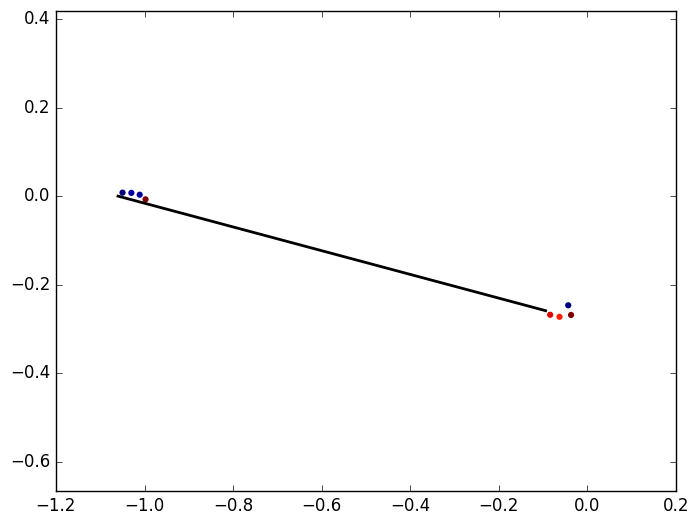

(-1.2000000000000002,0.19999999999999996,-0.30000000000000004,0.04999999999999999)

In [27]:
view_vorts(surf2d[10],field2d[10])
axis("equal")

In [28]:
 t = t + dt

        for i = 1:surf.nspan
            #Update kinematic parameters
            update_kinem(surf2d[i], t)

            #Update flow field parameters if any
            update_externalvel(field2d[i], t)

            #Update bound vortex positions
            update_boundpos(surf2d[i], dt)

            #Add a TEV with dummy strength
            place_tev(surf2d[i], field2d[i], dt)
        end

        kelv = KelvinConditionLLTldvm(surf, surf2d, field2d)

        #Solve for TEV strength to satisfy Kelvin condition

        soln = nlsolve(not_in_place(kelv), -0.01*ones(surf.nspan), method = :newton)

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]

            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

        for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)

        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

    #end

In [29]:
nshed = Int(0)
        for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #2D iteration if LESP_crit is exceeded
            if abs(surf2d[i].a0[1]) > surf2d[i].lespcrit[1]
                #Remove the previous tev
                pop!(field2d[i].tev)
                #Add a TEV with dummy strength
                place_tev(surf2d[i],field2d[i],dt)

                #Add a LEV with dummy strength
                place_lev(surf2d[i],field2d[i],dt)
                surf2d[i].levflag[1] = 1
                nshed += 1
            else
                surf2d[i].levflag[1] = 0
            end
        end

In [30]:
 if nshed > 0
            kelvkutta = KelvinKuttaLLTldvm(surf,surf2d,field2d, nshed)

            #Solve for TEV and LEV strengths to satisfy Kelvin condition and Kutta condition at leading edge
            soln = nlsolve(not_in_place(kelvkutta), [-0.01*ones(surf.nspan); 0.01*ones(nshed)], method = :newton)
        end







Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
 * Zero: [-0.0056377,-0.0077078,-0.0181253,-0.0143441,-0.0154772,-0.0151221,-0.0153167,-0.0151924,-0.0153167,-0.0151221,-0.0154772,-0.0143441,-0.0181253,-0.0077078,-0.0056377,0.0231211,0.0151706,0.0178021,0.0171715,0.0176406,0.0173944,0.0176406,0.0171715,0.0178021,0.0151706,0.0231211]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 1

In [31]:
  cntr = surf.nspan + 1

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]
        end
        for i = 1:surf.nspan
            if surf2d[i].levflag[1] == 1
                field2d[i].lev[length(field2d[i].lev)].s = soln.zero[cntr]
                cntr += 1
            end
        end


    for i = 1:surf.nspan
            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

  for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)


        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

  for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #Update rest of Fourier terms
            update_a2toan(surf2d[i])

            #Update derivatives of Fourier coefficients
            update_adot(surf2d[i],dt)

            #Set previous values of aterm to be used for derivatives in next time step
            surf2d[i].a0prev[1] = surf2d[i].a0[1]
            for ia = 1:3
                surf2d[i].aprev[ia] = surf2d[i].aterm[ia]
            end

            #Calculate bound vortex strengths
            update_bv(surf2d[i])

            wakeroll(surf2d[i], field2d[i], dt)

            if (surf2d[i].levflag[1] == 1)
                cl[i], cd[i], cm[i] = calc_forces_E(surf2d[i], field2d[i].lev[length(field2d[i].lev)].s, dt)
            else
                cl[i], cd[i], cm[i] = calc_forces(surf2d[i])
            end

        end
  cl3d = 0
        cd3d = 0
        cm3d = 0

        for i = 1:surf.nspan-1
            cl3d = cl3d + 0.5*(cl[i] + cl[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cd3d = cd3d + 0.5*(cd[i] + cd[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cm3d = cm3d + 0.5*(cm[i] + cm[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
        end

        mat = hcat(mat, [t, cl3d, cd3d, cm3d])
       
      
    
      

      

      

4×5 Array{Float64,2}:
  0.015    0.03      0.045     0.06      0.075   
 26.669    0.968096  0.989264  1.01103   1.01635 
  7.06945  0.182958  0.188737  0.195019  0.196845
 -9.60843  1.78866   1.66171   1.69744   1.72809 

In [59]:
t = t + dt
        for i = 1:surf.nspan
            #Update kinematic parameters
            update_kinem(surf2d[i], t)

            #Update flow field parameters if any
            update_externalvel(field2d[i], t)

            #Update bound vortex positions
            update_boundpos(surf2d[i], dt)

            #Add a TEV with dummy strength
            place_tev(surf2d[i], field2d[i], dt)
        end

        kelv = KelvinConditionLLTldvm(surf, surf2d, field2d)

        #Solve for TEV strength to satisfy Kelvin condition

        soln = nlsolve(not_in_place(kelv), -0.01*ones(surf.nspan), method = :newton)

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]

            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

        for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)

        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

    #end
    
    nshed = Int(0)
        for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #2D iteration if LESP_crit is exceeded
            if abs(surf2d[i].a0[1]) > surf2d[i].lespcrit[1]
                #Remove the previous tev
                pop!(field2d[i].tev)
                #Add a TEV with dummy strength
                place_tev(surf2d[i],field2d[i],dt)

                #Add a LEV with dummy strength
                place_lev(surf2d[i],field2d[i],dt)
                surf2d[i].levflag[1] = 1
                nshed += 1
            else
                surf2d[i].levflag[1] = 0
            end
        end
    
     if nshed > 0
            kelvkutta = KelvinKuttaLLTldvm(surf,surf2d,field2d, nshed)

            #Solve for TEV and LEV strengths to satisfy Kelvin condition and Kutta condition at leading edge
            soln = nlsolve(not_in_place(kelvkutta), [-0.01*ones(surf.nspan); 0.01*ones(nshed)], method = :newton)
        end



  cntr = surf.nspan + 1

        for i = 1:surf.nspan
            field2d[i].tev[length(field2d[i].tev)].s = soln.zero[i]
        end
        for i = 1:surf.nspan
            if surf2d[i].levflag[1] == 1
                field2d[i].lev[length(field2d[i].lev)].s = soln.zero[cntr]
                cntr += 1
            end
        end


    for i = 1:surf.nspan
            #Update incduced velocities on airfoil
            update_indbound(surf2d[i], field2d[i])

            #Calculate downwash
            update_downwash(surf2d[i], [field2d[i].u[1],field2d[i].w[1]])

            #Calculate first two fourier coefficients
            update_a0anda1(surf2d[i])

            bc[i] = surf2d[i].a0[1] + 0.5*surf2d[i].aterm[1]
        end

  for i = 1:surf.nspan
            for n = 1:surf.nbterm
                lhs[i,n] = sin(n*surf.psi[i])*(sin(surf.psi[i]) + (n*pi/(2*AR)))
            end
            rhs[i] = pi*sin(surf.psi[i])*bc[i]/(2*AR)
        end
        bcoeff[:] = \(lhs, rhs)


        for i = 1:surf.nspan
            a03d[i] = 0
            for n = 1:surf.nbterm
            a03d[i] = a03d[i] - real(n)*bcoeff[n]*sin(n*surf.psi[i])/sin(surf.psi[i])
            end
        end

  for i = 1:surf.nspan
            #Update 3D effect on A0
            surf2d[i].a0[1] = surf2d[i].a0[1] + a03d[i]

            #Update rest of Fourier terms
            update_a2toan(surf2d[i])

            #Update derivatives of Fourier coefficients
            update_adot(surf2d[i],dt)

            #Set previous values of aterm to be used for derivatives in next time step
            surf2d[i].a0prev[1] = surf2d[i].a0[1]
            for ia = 1:3
                surf2d[i].aprev[ia] = surf2d[i].aterm[ia]
            end

            #Calculate bound vortex strengths
            update_bv(surf2d[i])

            wakeroll(surf2d[i], field2d[i], dt)

            if (surf2d[i].levflag[1] == 1)
                cl[i], cd[i], cm[i] = calc_forces_E(surf2d[i], field2d[i].lev[length(field2d[i].lev)].s, dt)
            else
                cl[i], cd[i], cm[i] = calc_forces(surf2d[i])
            end

        end
  cl3d = 0
        cd3d = 0
        cm3d = 0

        for i = 1:surf.nspan-1
            cl3d = cl3d + 0.5*(cl[i] + cl[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cd3d = cd3d + 0.5*(cd[i] + cd[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
            cm3d = cm3d + 0.5*(cm[i] + cm[i+1])*sin(0.5*(surf.psi[i] + surf.psi[i+1]))*(surf.psi[i+1] - surf.psi[i])/2
        end

        mat = hcat(mat, [t, cl3d, cd3d, cm3d])
       
      
    
      

      

   



4×16 Array{Float64,2}:
  0.015    0.03      0.045     0.06      …  0.195     0.21      0.225   
 26.669    0.968096  0.989264  1.01103      0.996267  1.03103   1.02054 
  7.06945  0.182958  0.188737  0.195019     0.209365  0.220529  0.212515
 -9.60843  1.78866   1.66171   1.69744      1.49125   1.5916    1.59371 

In [60]:
soln


Results of Nonlinear Solver Algorithm
 * Algorithm: Newton with line-search
 * Starting Point: [-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,-0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.01]
 * Zero: [-0.000587228,-0.000307256,-0.0228112,0.00199335,-0.0153136,-0.00257536,-0.010438,-0.00491482,-0.010438,-0.00257536,-0.0153136,0.00199335,-0.0228112,-0.000307256,-0.000587228,0.0397386,0.00478405,0.0265931,0.0119087,0.0265931,0.00478405,0.0397386]
 * Inf-norm of residuals: 0.000000
 * Iterations: 1
 * Convergence: true
   * |x - x'| < 0.0e+00: false
   * |f(x)| < 1.0e-08: true
 * Function Calls (f): 2
 * Jacobian Calls (df/dx): 1

In [61]:
for i = 1:surf.nspan
    surf.a0[i] = surf2d[i].a0[1]
end

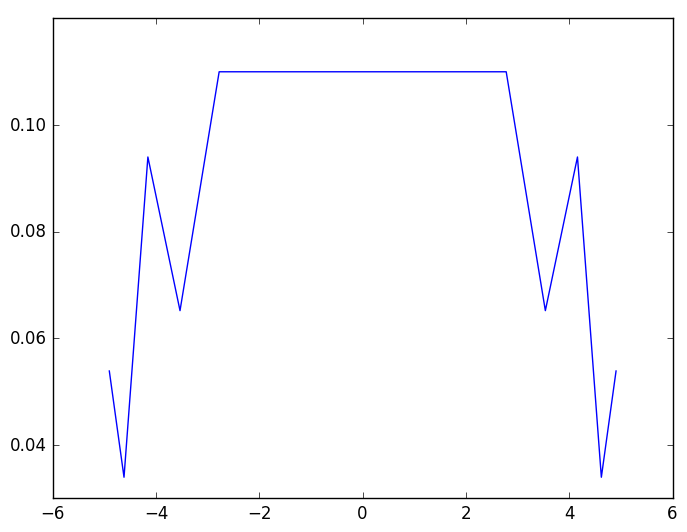

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x3287bf6d0>

In [62]:
plot(surf.yle,surf.a0)

In [36]:
kelv = kelvkutta

UNSflow.KelvinKuttaLLTldvm(UNSflow.ThreeDSurf(1.0,10.0,10.0,1.0,UNSflow.patch[UNSflow.patch(0.0,-5.0,0.0,0.0,"FlatPlate",1.0,0.0,0.11,7),UNSflow.patch(0.0,0.0,0.0,0.0,"FlatPlate",1.0,0.0,0.11,7),UNSflow.patch(0.0,5.0,0.0,0.0,"FlatPlate",1.0,0.0,0.11,5)],70,15,35,15,UNSflow.KinemDef3D(UNSflow.ConstDef(0.2617993877991494),UNSflow.ConstDef(0.0),UNSflow.ConstDef(1.0),"Constant",0,[0.0]),[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0],[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0],[0.0,0.0455303,0.0910607,0.136591,0.182121,0.227652,0.273182,0.318712,0.364243,0.409773  …  2.73182,2.77735,2.82288,2.86841,2.91394,2.95947,3.005,3.05053,3.09606,3.14159],[0.19635,0.392699,0.589049,0.785398,0.981748,1.1781,1.37445,1.5708,1.76715,1.9635,2.15984,2.35619,2.55254,2.74889,2.94524],[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 

In [37]:
val = zeros(kelv.surf3d.nspan + kelv.nshed)
bc = zeros(kelv.surf3d.nspan)

    cntr = kelv.surf3d.nspan + 1

for i = 1:kelv.surf3d.nspan
        nlev = length(kelv.field[i].lev)
        ntev = length(kelv.field[i].tev)
       

        #Update incduced velocities on airfoil
        update_indbound(kelv.surf[i], kelv.field[i])

        #Calculate downwash
        update_downwash(kelv.surf[i], [kelv.field[i].u[1],kelv.field[i].w[1]])

        #Calculate first two fourier coefficients
        update_a0anda1(kelv.surf[i])

        bc[i] = kelv.surf[i].a0[1] + 0.5*kelv.surf[i].aterm[1]

        val[i] = kelv.surf[i].uref*kelv.surf[i].c*pi*(kelv.surf[i].a0[1] + kelv.surf[i].aterm[1]/2.)

        for iv = 1:ntev
            val[i] = val[i] + kelv.field[i].tev[iv].s
        end
        for iv = 1:nlev
            val[i] = val[i] + kelv.field[i].lev[iv].s
        end

        if kelv.surf[i].levflag[1] == 1
            if kelv.surf[i].a0[1] > 0
                lesp_cond = kelv.surf[i].lespcrit[1]
            else
                lesp_cond = -kelv.surf[i].lespcrit[1]
            end
            val[cntr-1] = kelv.surf[i].a0[1] - lesp_cond
        end
    end

    AR = kelv.surf3d.bref/kelv.surf3d.cref
    lhs = zeros(kelv.surf3d.nspan,kelv.surf3d.nbterm)
    rhs = zeros(kelv.surf3d.nspan)
    bcoeff = zeros(kelv.surf3d.nbterm)

    for j = 1:kelv.surf3d.nspan
        for n = 1:kelv.surf3d.nbterm
            lhs[j,n] = sin(n*kelv.surf3d.psi[j])*(sin(kelv.surf3d.psi[j]) + (n*pi/(2*AR)))
        end
        rhs[j] = pi*sin(kelv.surf3d.psi[j])*bc[j]/(2*AR)
    end
    bcoeff[:] = \(lhs, rhs)

    a03d = zeros(kelv.surf3d.nspan)

    for j = 1:kelv.surf3d.nspan
        a03d[j] = 0
        for n = 1:kelv.surf3d.nbterm
            a03d[j] = a03d[j] - real(n)*bcoeff[n]*sin(n*kelv.surf3d.psi[j])/sin(kelv.surf3d.psi[j])
        end
    end

    cntr = kelv.surf3d.nspan + 1
    for i = 1:kelv.surf3d.nspan
        val[i] = val[i] + kelv.surf[i].uref*kelv.surf[i].c*pi*a03d[i]
        if kelv.surf[i].levflag[1] == 1
            val[cntr] = val[cntr] + a03d[i]
            cntr += 1
        end
    end

In [38]:
val

26-element Array{Float64,1}:
  0.002045  
  0.00442343
  0.00778323
  0.00835507
  0.0090758 
  0.00937502
  0.00956895
  0.00960792
  0.00956895
  0.00937502
  0.0090758 
  0.00835507
  0.00778323
  0.00442343
  0.002045  
  0.0121353 
 -0.0102592 
 -0.00200781
 -0.00380561
 -0.00230897
 -0.00303555
 -0.00230897
 -0.00380561
 -0.00200781
 -0.0102592 
  0.0121353 